In [1]:
import ast
import numpy as np
import pandas as pd
from area import area
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
import shap as shap

from hyperopt import fmin, tpe, hp, STATUS_OK, STATUS_FAIL, Trials
from hyperopt.pyll import scope

%matplotlib inline

In [2]:
SEED = 797

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [3]:
df_train = pd.read_csv("train_dataset_train.csv")

In [4]:
def add_features(data: pd.DataFrame) -> pd.DataFrame:
    df = data.copy()
    df['.geo_lat'] = df['.geo'].apply(lambda x: 
                                        ( 
                                            ast.literal_eval(x)['coordinates'][0][0][0][0] 
                                            if isinstance(ast.literal_eval(x)['coordinates'][0][0][0], list) 
                                            else ast.literal_eval(x)['coordinates'][0][0][0]
                                        )
                                        if ast.literal_eval(x).get('coordinates')
                                        else ast.literal_eval(x)['geometries'][0]['coordinates'][0][0]
                                    )
    df['.geo_lon'] = df['.geo'].apply(lambda x: 
                                        (
                                            ast.literal_eval(x)['coordinates'][0][0][0][1] 
                                            if isinstance(ast.literal_eval(x)['coordinates'][0][0][1], list) 
                                            else ast.literal_eval(x)['coordinates'][0][0][1]
                                        )
                                        if ast.literal_eval(x).get('coordinates')
                                        else ast.literal_eval(x)['geometries'][0]['coordinates'][0][1]
                                    )
    df['.geo_area'] = df['.geo'].apply(lambda x: area(ast.literal_eval(x))) / 10000
    ndvi_columns = [nd for nd in df.columns if 'nd_mean' in nd]
    df['ndvi_miss_count'] = df[ndvi_columns].eq(0).sum(axis=1)
    df['ndvi_max'] = df[ndvi_columns].max(axis=1)
    df['ndvi_mean'] = df.replace(0, np.NaN)[ndvi_columns].mean(axis=1)
    return df

In [5]:
NUM_FEATURES = [
       #'area', 
       '.geo_area',
       'nd_mean_2021-04-16', 'nd_mean_2021-04-19',
       'nd_mean_2021-04-22', 'nd_mean_2021-04-26', 'nd_mean_2021-04-28',
       'nd_mean_2021-05-02', 'nd_mean_2021-05-04', 'nd_mean_2021-05-07',
       'nd_mean_2021-05-16', 'nd_mean_2021-05-17', 'nd_mean_2021-05-21',
       'nd_mean_2021-05-26', 'nd_mean_2021-05-27', 'nd_mean_2021-05-29',
       'nd_mean_2021-06-06', 'nd_mean_2021-06-09', 'nd_mean_2021-06-13',
       'nd_mean_2021-06-16', 'nd_mean_2021-06-18', 'nd_mean_2021-06-19',
       'nd_mean_2021-06-20', 'nd_mean_2021-06-22', 'nd_mean_2021-06-25',
       'nd_mean_2021-06-27', 'nd_mean_2021-07-07', 'nd_mean_2021-07-08',
       'nd_mean_2021-07-09', 'nd_mean_2021-07-13', 'nd_mean_2021-07-15',
       'nd_mean_2021-07-17', 'nd_mean_2021-07-20', 'nd_mean_2021-07-26',
       'nd_mean_2021-07-27', 'nd_mean_2021-07-29', 'nd_mean_2021-07-31',
       'nd_mean_2021-08-07', 'nd_mean_2021-08-12',
       'nd_mean_2021-04-15', 'nd_mean_2021-04-18', 'nd_mean_2021-04-25',
       'nd_mean_2021-04-27', 'nd_mean_2021-04-29', 'nd_mean_2021-04-30',
       'nd_mean_2021-06-07', 'nd_mean_2021-06-12', 'nd_mean_2021-06-28',
       'nd_mean_2021-08-01', 'nd_mean_2021-08-11', 'nd_mean_2021-05-01',
       'nd_mean_2021-05-03', 'nd_mean_2021-05-10', 'nd_mean_2021-05-15',
       'nd_mean_2021-06-02', 'nd_mean_2021-06-03', 'nd_mean_2021-07-04',
       'nd_mean_2021-08-10', 'nd_mean_2021-08-23', 'nd_mean_2021-04-20',
       'nd_mean_2021-04-23', 'nd_mean_2021-05-09', 'nd_mean_2021-05-19',
       'nd_mean_2021-05-20', 'nd_mean_2021-06-04', 'nd_mean_2021-06-05',
       'nd_mean_2021-06-10', 'nd_mean_2021-07-05', 'nd_mean_2021-08-13',
       'nd_mean_2021-08-27', 'nd_mean_2021-05-08', 'nd_mean_2021-05-24',
       '.geo_lat', '.geo_lon', 'ndvi_miss_count', 'ndvi_max', #'ndvi_mean'
]
ALL_FEATURES = NUM_FEATURES
TARGET = 'crop'

In [6]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), NUM_FEATURES),
        #("cat", categorical_transformer, CAT_FEATURES),
    ],
    verbose = True, remainder='passthrough', n_jobs = -1
)

data_pipeline = Pipeline(
    steps = [
        ('preprocess', preprocess),
    ],
    verbose = True
)

In [7]:
X_train = add_features(data=df_train)[ALL_FEATURES]
y_train = df_train[TARGET]

X_train = data_pipeline.fit_transform(X_train)

[ColumnTransformer] ........... (1 of 1) Processing num, total=   0.0s
[Pipeline] ........ (step 1 of 1) Processing preprocess, total=   1.2s


In [8]:
X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=777)

### Hyperopt

In [1]:
import mlflow

# S3 Object Storage of Yandex Cloud
%env AWS_REGION = <>
%env AWS_ACCESS_KEY_ID = <>
%env AWS_SECRET_ACCESS_KEY = <>

# MLflow
%env MLFLOW_SERVER_HOST = <>
%env MLFLOW_SERVER_PORT = <>


mlflow.set_tracking_uri(
    f"http://{os.environ['MLFLOW_SERVER_HOST']}:{os.environ['MLFLOW_SERVER_PORT']}"
)
print(f"tracking MLflow URI: '{mlflow.get_tracking_uri()}'")
print(f"{mlflow.list_experiments()}")
mlflow.set_experiment("agroculture-classification-innopolis")

env: AWS_REGION=<>
env: AWS_ACCESS_KEY_ID=<>
env: AWS_SECRET_ACCESS_KEY=<>
env: MLFLOW_SERVER_HOST=<>
env: MLFLOW_SERVER_PORT=<>


### 1

In [10]:
# Define parameter space, fit conditions
ctb_clf_params = {
    #'learning_rate': hp.choice('learning_rate', np.linspace(0.01,0.1,10)),
    'max_depth': hp.quniform('max_depth', 3, 11, 1),
    'colsample_bylevel': hp.uniform('colsample_bylevel', 0.7, 1.0),
    'iterations': hp.quniform('iterations', 2000, 15000, 1000),
    'l2_leaf_reg': hp.quniform('l2_leaf_reg', 0, 20, 1),
    'min_data_in_leaf': hp.quniform('min_data_in_leaf', 2, 8, 2),
    #'bagging_temperature': hp.uniform('bagging_temperature', 0, 300),
    'bootstrap_type': hp.choice('bootstrap_type', ['Bernoulli', 'Bayesian']),
    # 'ignored_features': hp.choice('ignored_features', [['ndvi_miss_count'], ['ndvi_max'], ['ndvi_mean']]),
    'class_weights':  hp.choice('class_weights', [[1.2, 1.0, 1.0, 1.0, 1.2, 1.0, 1.0], [2.0, 0.8, 0.8, 0.8, 2.0, 0.8, 2.0]]),
    'loss_function': 'MultiClass',
    'random_seed': SEED,
}
ctb_fit_params = {
    'early_stopping_rounds': 200,
    'verbose': False,
}
ctb_para = dict()
ctb_para['clf_params'] = ctb_clf_params
ctb_para['fit_params'] = ctb_fit_params

In [14]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "catboost")
        mlflow.set_tag("hp", "yes")
        mlflow.log_param("model", "catboost")
        mlflow.log_params(params)
        clf = CatBoostClassifier(**params)
        booster = clf.fit(X_train_train, y_train_train,
                          eval_set=[(X_train_train, y_train_train), (X_val, y_val)],
                          **ctb_para['fit_params'])
        y_pred = booster.predict(X_val)
        metrics = classification_report(y_val, y_pred, digits=4, output_dict=True)
        # recall_macro = recall_score(X_val, pred, average='macro')
        # recall_micro = recall_score(X_val, pred, average='micro')
        # f1_macro = f1_score(X_val, pred, average='macro')
        # f1_micro = f1_score(X_val, pred, average='micro')
        mlflow.log_metric("recall_macro", metrics['macro avg']['recall'])
        mlflow.log_metric("precision_macro", metrics['macro avg']['precision'])
        mlflow.log_metric("f1_macro", metrics['macro avg']['f1-score'])
        mlflow.log_metric("accuracy", metrics['accuracy'])
        mlflow.log_metric("recall_0", metrics['0']['recall'])
        mlflow.log_metric("f1_0", metrics['0']['f1-score'])
        mlflow.log_metric("recall_1", metrics['1']['recall'])
        mlflow.log_metric("f1_1", metrics['1']['f1-score'])
        mlflow.log_metric("recall_2", metrics['2']['recall'])
        mlflow.log_metric("f1_2", metrics['2']['f1-score'])
        mlflow.log_metric("recall_3", metrics['3']['recall'])
        mlflow.log_metric("f1_3", metrics['3']['f1-score'])
        mlflow.log_metric("recall_4", metrics['4']['recall'])
        mlflow.log_metric("f1_4", metrics['4']['f1-score'])
        mlflow.log_metric("recall_5", metrics['5']['recall'])
        mlflow.log_metric("f1_5", metrics['5']['f1-score'])
        mlflow.log_metric("recall_6", metrics['6']['recall'])
        mlflow.log_metric("f1_6", metrics['6']['f1-score'])

    return {'loss': metrics['macro avg']['recall'], 'status': STATUS_OK}

In [15]:
# trials will contain logging information
trials = Trials()

best_result = fmin(
    fn=objective,
    space=ctb_para['clf_params'],
    algo=tpe.suggest,
    max_evals=140,
    trials=trials
)

100%|██████████| 140/140 [18:07:50<00:00, 466.22s/trial, best loss: 0.9584335727056935]    


In [17]:
best_result

{'bootstrap_type': 1,
 'class_weights': 1,
 'colsample_bylevel': 0.9302772209536949,
 'iterations': 4000.0,
 'l2_leaf_reg': 16.0,
 'max_depth': 4.0,
 'min_data_in_leaf': 2.0}

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

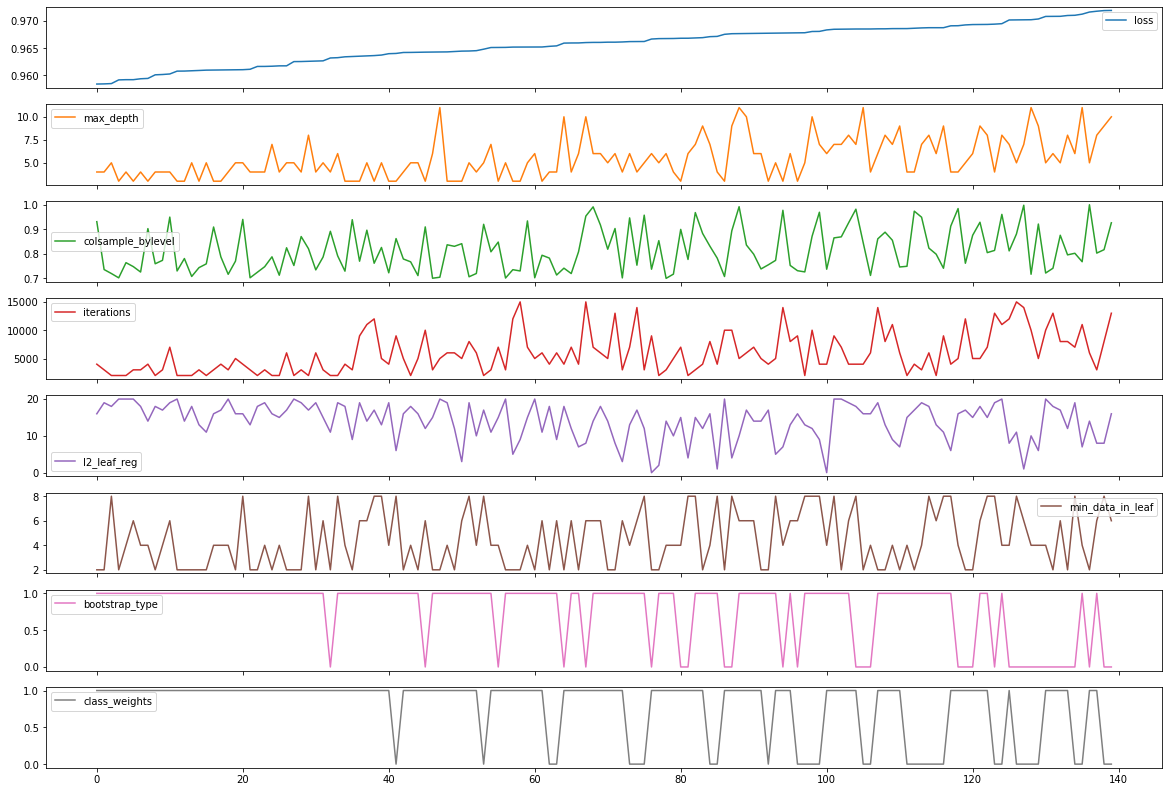

In [18]:
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['colsample_bylevel'][0],
                      x['misc']['vals']['iterations'][0],
                      x['misc']['vals']['l2_leaf_reg'][0],
                      x['misc']['vals']['min_data_in_leaf'][0],
                      x['misc']['vals']['bootstrap_type'][0],
                      x['misc']['vals']['class_weights'][0]]
                        for x in trials.trials]
                    )

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['loss', 'max_depth', 'colsample_bylevel', 'iterations',
                                    'l2_leaf_reg', 'min_data_in_leaf', 'bootstrap_type', 'class_weights'])
tpe_results_df = tpe_results_df.sort_values('loss').reset_index(drop=True)
tpe_results_df.plot(subplots=True,figsize=(20, 14))